In [105]:
# Import Packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [106]:
# Import Data
data = pd.read_csv("data/online_retail_II.csv")
print(data.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [107]:
# Data cleaning
# Drop Duplicates
data = data.drop_duplicates()
# Trash Types to clean 
trash_codes = [
    'POST', 'D', 'M', 'C2', 'BANK CHARGES', 
    'TEST001', 'TEST002', 'PADS', 'ADJUST', 
    'ADJUST2', 'SP1002', 'DOT', 'CRUK'
]
# fixing data"
data = data[~data['StockCode'].isin(trash_codes)]
# Remove rows with Price <= 0 (Free items, errors, adjustments)
data = data[data['Price'] > 0]
# Change datatype to dataframe for Data
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
# Drop null Customers ID
data = data.dropna(subset=['Customer ID'])
# Returns
data['IsReturn'] = data['Invoice'].astype(str).str.startswith('C')
# Separate value for Purchase and Return Amount
data['PurchaseAmount'] = np.where(data['IsReturn'] == False, data['Quantity'] * data['Price'], 0)
data['ReturnAmount']   = np.where(data['IsReturn'] == True,  (data['Quantity'] * data['Price']).abs(), 0)
# Net Revenue
data['NetRevenue'] = data['PurchaseAmount'] - data['ReturnAmount']
# snapshot date
snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
# purchase only to avoid unrealistic Recency
purchases = data[data['Quantity'] > 0]# create values
rfm = purchases.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'Invoice': 'nunique',                                   # Frequency
})
# monetary for all data
monetary_df = data.groupby('Customer ID')['NetRevenue'].sum()
rfm = rfm.join(monetary_df)
rfm.columns = ['Recency', 'Frequency', 'Monetary']
# Last 90 days and last 90 days before previous 90 days
cutoff_180 = snapshot_date - pd.Timedelta(days=180)
cutoff_360 = cutoff_180 - pd.Timedelta(days=180)
purchases_recent = purchases[purchases['InvoiceDate'] >= cutoff_180]
purchases_prev = purchases[(purchases['InvoiceDate'] < cutoff_180) & (purchases['InvoiceDate'] >= cutoff_360)]
# Calulating metrics for 2 dates
recent_metrics = purchases_recent.groupby('Customer ID').agg({'Invoice': 'nunique', 'NetRevenue': 'sum'})
prev_metrics = purchases_prev.groupby('Customer ID').agg({'Invoice': 'nunique', 'NetRevenue': 'sum'})
recent_metrics.columns = ['Recent_Frequency', 'Recent_Monetary']
prev_metrics.columns = ['Prev_Frequency', 'Prev_Monetary']
rfm = rfm.join(recent_metrics).join(prev_metrics).fillna(0)
# Creating Delta Values
rfm["Frequency_delta"] = (rfm["Recent_Frequency"] + 1) / (rfm["Prev_Frequency"] + 1)
rfm["Monetary_delta"] = (rfm["Recent_Monetary"] + 1) / (rfm["Prev_Monetary"] + 1)

In [108]:
# A. Tenure (Days since first purchase)
tenure = data.groupby('Customer ID')['InvoiceDate'].min().reset_index()
tenure['Tenure'] = (snapshot_date - tenure['InvoiceDate']).dt.days
tenure = tenure.set_index('Customer ID')['Tenure']

# B. Inter-purchase Time (Buying Rhythm)
# Sort data to calculate the gap between orders
data_sorted = data.sort_values(['Customer ID', 'InvoiceDate'])
data_sorted['Prev_Date'] = data_sorted.groupby('Customer ID')['InvoiceDate'].shift(1)
data_sorted['Days_Diff'] = (data_sorted['InvoiceDate'] - data_sorted['Prev_Date']).dt.days

# Calculate Mean and Std Dev of the gap
ipt = data_sorted.groupby('Customer ID').agg({
    'Days_Diff': ['mean', 'std']
})
ipt.columns = ['IPT_Mean', 'IPT_Std']
ipt = ipt.fillna(0) # Fill NaNs for one-time buyers

# C. Behavioral Features
behavior = data.groupby('Customer ID').agg({
    'IsReturn': 'mean',        # Return Rate (% of transactions that are returns)
    'StockCode': 'nunique',    # Basket Diversity (Unique items bought)
    'Quantity': 'mean'         # Average Basket Size
})
behavior.columns = ['ReturnRate', 'BasketDiversity', 'AvgBasketSize']

# 2. MERGE
rfm = rfm.join(tenure).join(ipt).join(behavior).fillna(0)

# 3. DERIVED FEATURES & TARGET

# AOV (Average Order Value)
rfm['AOV'] = rfm['Monetary'] / (rfm['Frequency'] + 1)

# SMART CHURN DEFINITION
# Logic: Threshold = 3x their average gap (IPT), but at least 90 days.
rfm['Churn_Threshold'] = rfm['IPT_Mean'] * 3
rfm['Churn_Threshold'] = rfm['Churn_Threshold'].clip(lower=90)

# Define Churn: Has it been longer than their personal threshold?
# 1 = Left, 0 = Stayed
rfm['Churn'] = (rfm['Recency'] > rfm['Churn_Threshold']).astype(int)

# --- VERIFICATION ---
print("RFM Table Shape:", rfm.shape)
print("Smart Churn Distribution:")
print(rfm['Churn'].value_counts())
display(rfm.head())

RFM Table Shape: (5852, 18)
Smart Churn Distribution:
Churn
1    2942
0    2910
Name: count, dtype: int64


,Recency,Frequency,Monetary,Recent_Frequency,Recent_Monetary,Prev_Frequency,Prev_Monetary,Frequency_delta,Monetary_delta,Tenure,IPT_Mean,IPT_Std,ReturnRate,BasketDiversity,AvgBasketSize,AOV,Churn_Threshold,Churn
Customer ID,,,,,,,,,,,,,,,,,,
12346.0,326,3,169.36,0.0,0.00,1.0,77183.60,0.5,0.000013,647,12.840000,46.102856,0.038462,25,0.923077,42.340000,90.0,1
12347.0,2,8,4921.53,3.0,2104.05,3.0,1494.16,1.0,1.407910,404,1.805430,10.487359,0.000000,126,13.364865,546.836667,90.0,0
12348.0,75,5,1658.40,1.0,270.00,3.0,1167.24,0.5,0.231973,438,8.044444,30.089983,0.000000,24,58.782609,276.400000,90.0,0
12349.0,19,3,3654.54,1.0,1457.55,0.0,0.00,2.0,1458.550000,736,4.068182,34.015558,0.028249,138,9.129944,913.635000,90.0,0
12350.0,310,1,294.40,0.0,0.00,1.0,294.40,0.5,0.003385,310,0.000000,0.000000,0.000000,16,12.250000,147.200000,90.0,1


In [109]:
# 1. Define X (features) and y (target)
# Remove "Recency" to avoid Data Leakage 
# Same with Churn
X = rfm.drop(['Churn', 'Recency', 'Churn_Threshold'], axis=1)
y = rfm['Churn']

# 2. 80% Train 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("--- SUMMARY ---")
print(f"All Clients: {len(rfm)}")
print(f"Train: {len(X_train)}")
print(f"Test: {len(X_test)}")
print("\nFeatures (X):")
print(list(X.columns))

--- SUMMARY ---
All Clients: 5852
Train: 4681
Test: 1171

Features (X):
['Frequency', 'Monetary', 'Recent_Frequency', 'Recent_Monetary', 'Prev_Frequency', 'Prev_Monetary', 'Frequency_delta', 'Monetary_delta', 'Tenure', 'IPT_Mean', 'IPT_Std', 'ReturnRate', 'BasketDiversity', 'AvgBasketSize', 'AOV']


In [110]:
# --- STEP 1: Initialize the Model ---
# n_estimators=100 -> We create a forest of 100 decision trees (voters)
# max_depth=6      -> Limit tree depth to prevent overfitting (memorizing data)
# random_state=42  -> Ensures reproducible results
rf_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)

# --- STEP 2: Train the Model (Fit) ---
# The model learns patterns from X_train to predict y_train
print("Training the Random Forest model... Please wait.")
rf_model.fit(X_train, y_train)

# --- STEP 3: Make Predictions ---
# We ask the model to predict Churn for the Test Set (unseen data)
y_pred = rf_model.predict(X_test)

# --- STEP 4: Evaluate Performance ---
# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"Model Accuracy: {accuracy:.2%}") # Display as percentage
print("(0 = Left, 1 = Stayed)")
print("-" * 30)
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred))

Training the Random Forest model... Please wait.
------------------------------
Model Accuracy: 92.83%
(0 = Left, 1 = Stayed)
------------------------------
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       569
           1       1.00      0.86      0.93       602

    accuracy                           0.93      1171
   macro avg       0.93      0.93      0.93      1171
weighted avg       0.94      0.93      0.93      1171



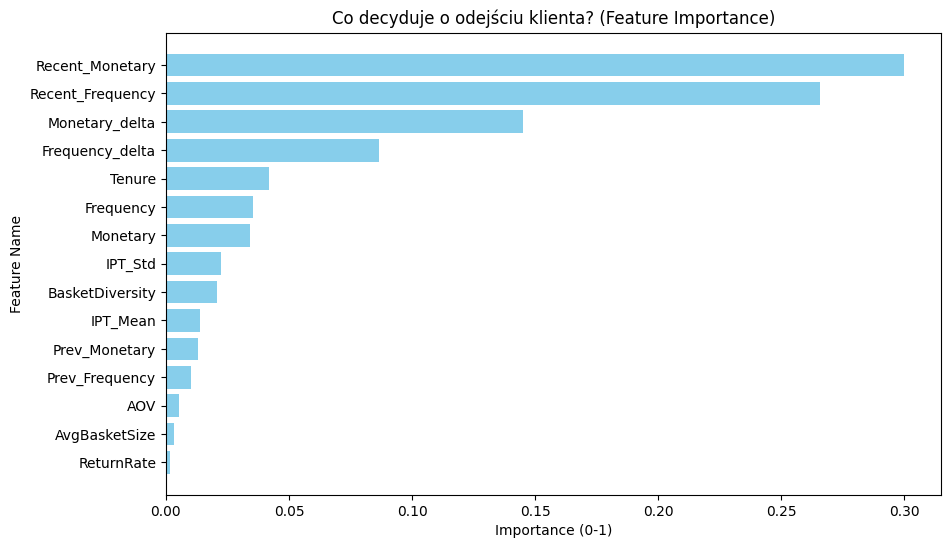

             Feature  Importance
3    Recent_Monetary    0.299855
2   Recent_Frequency    0.265733
7     Monetary_delta    0.145048
6    Frequency_delta    0.086482
8             Tenure    0.042043
0          Frequency    0.035408
1           Monetary    0.034130
10           IPT_Std    0.022542
12   BasketDiversity    0.020578
9           IPT_Mean    0.014049
5      Prev_Monetary    0.013212
4     Prev_Frequency    0.010216
14               AOV    0.005509
13     AvgBasketSize    0.003337
11        ReturnRate    0.001857


In [111]:
# Importances of features
importances = rf_model.feature_importances_
feature_names = X.columns

# Create Table
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Create Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance (0-1)')
plt.ylabel('Feature Name')
plt.title('Co decyduje o odejściu klienta? (Feature Importance)')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)

In [112]:
# --- STEP 4: RISK SEGMENTATION & CALL LIST ---

# 1. Get probabilities instead of just 0/1
# We are interested in the probability of Class 1 (Churn/Leaving)
# Note: W Twoim modelu 0=Left, 1=Stayed.
# Więc szukamy PRAWDOPODOBIEŃSTWA KLASY 0 (Odejście).
churn_prob = rf_model.predict_proba(X_test)[:, 0] 

# 2. Create a Results Table
results = pd.DataFrame({
    'Actual_Status': y_test,
    'Churn_Risk': churn_prob
}, index=X_test.index)

# 3. Define Risk Segments
def get_segment(prob):
    if prob > 0.80: return '🔴 Critical (Utracony)'
    if prob > 0.50: return '🟠 At Risk (Ratuj!)'
    if prob > 0.20: return '🟡 Watchlist (Obserwuj)'
    return '🟢 Safe (Bezpieczny)'

results['Segment'] = results['Churn_Risk'].apply(get_segment)

# 4. Show Summary
print("\n--- PODZIAŁ BAZY KLIENTÓW ---")
print(results['Segment'].value_counts())

# 5. Show Top Candidates for Campaign
print("\n--- Klienci 'At Risk' (Wysokie Ryzyko Odejścia) ---")
print("To do nich dzwonimy jutro z rabatem!")
display(results[results['Segment'] == '🟠 At Risk (Ratuj!)'].head(10))


--- PODZIAŁ BAZY KLIENTÓW ---
Segment
🟢 Safe (Bezpieczny)       483
🔴 Critical (Utracony)     450
🟠 At Risk (Ratuj!)        199
🟡 Watchlist (Obserwuj)     39
Name: count, dtype: int64

--- Klienci 'At Risk' (Wysokie Ryzyko Odejścia) ---
To do nich dzwonimy jutro z rabatem!


,Actual_Status,Churn_Risk,Segment
Customer ID,,,
16737.0,0,0.659750,🟠 At Risk (Ratuj!)
13583.0,1,0.776613,🟠 At Risk (Ratuj!)
17029.0,1,0.646422,🟠 At Risk (Ratuj!)
15488.0,0,0.762951,🟠 At Risk (Ratuj!)
16485.0,0,0.746757,🟠 At Risk (Ratuj!)
15986.0,0,0.790626,🟠 At Risk (Ratuj!)
12763.0,1,0.774461,🟠 At Risk (Ratuj!)
18262.0,1,0.721182,🟠 At Risk (Ratuj!)
15216.0,0,0.761835,🟠 At Risk (Ratuj!)


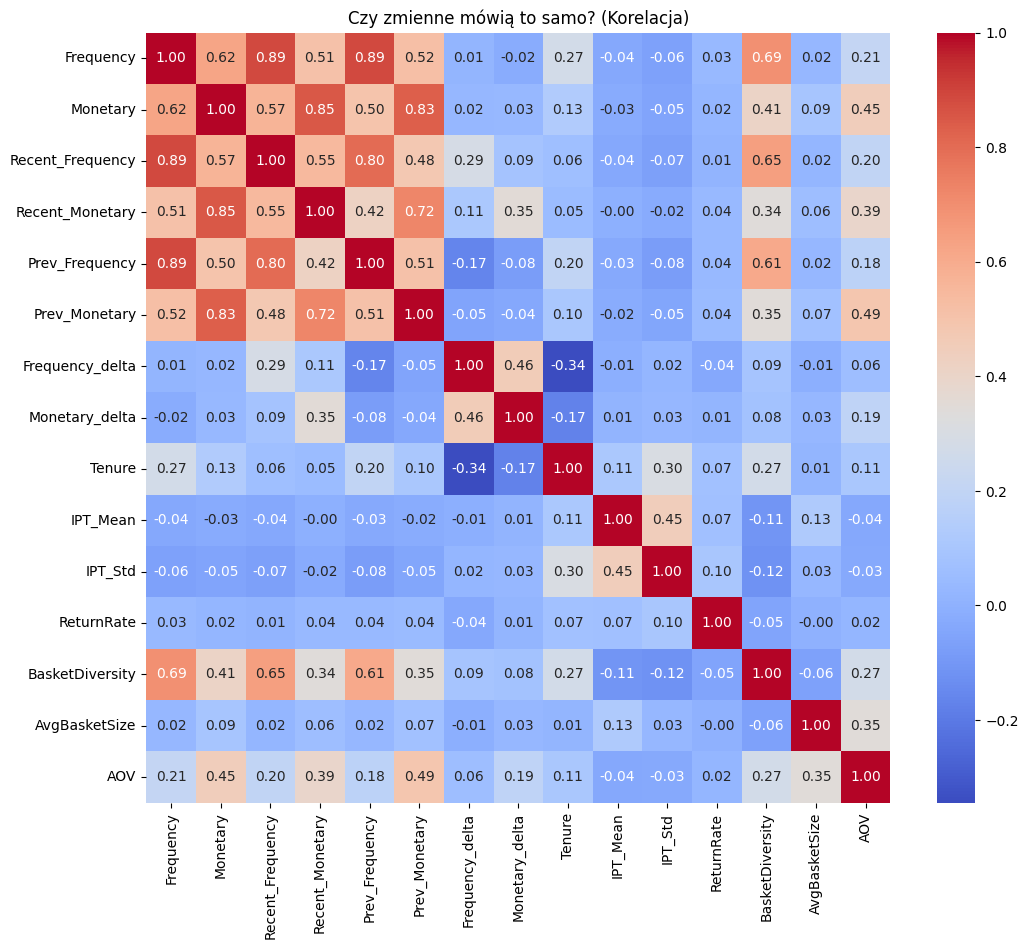

In [115]:
# Obliczamy korelację
plt.figure(figsize=(12, 10))
# Wybieramy tylko kolumny numeryczne z X
correlation = X.corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Czy zmienne mówią to samo? (Korelacja)")
plt.show()

In [117]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# --- KROK 3: ZAAWANSOWANE STROJENIE (Repeated Stratified CV) ---

# 1. Definiujemy procedurę "Pętla w Pętli"
# Dzielimy na 5 części, i powtarzamy to losowanie 3 razy.
# Razem 15 testów dla każdego ustawienia.
cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# 2. Definiujemy siatkę parametrów do sprawdzenia
# Ograniczyłem ją lekko, żebyś nie czekał godziny, ale nadal sprawdzi to co ważne.
param_grid = {
    'n_estimators': [100, 200],         # Liczba drzew
    'max_depth': [4, 6, 8],             # Głębokość (złożoność)
    'min_samples_leaf': [1, 2, 4],      # Minimalna wielkość liścia (ochrona przed przeuczeniem)
    'class_weight': ['balanced', None]  # Czy pomagać mniejszej klasie (Odeszli)?
}

print("🔍 Rozpoczynam Grid Search z podwójną pętlą walidacji...")
print("To może chwilę potrwać (testujemy każdą opcję 15 razy!)... ☕")

# 3. Konfigurujemy Grid Search
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv_method,        # Tu wpinamy naszą "super-walidację"
    scoring='accuracy',        # Optymalizujemy pod F1 (skuteczność wyłapywania odejść)
    n_jobs=-1,           # Używamy wszystkich rdzeni procesora
    verbose=1            # Będzie pisać postępy
)

# 4. Odpalamy maszynę
rf_grid.fit(X_train, y_train)

# 5. Wyniki
print("-" * 30)
print(f"🏆 Zwycięskie parametry: {rf_grid.best_params_}")
print(f"💎 Najlepszy średni wynik F1: {rf_grid.best_score_:.2%}")
print("-" * 30)

# 6. Podmieniamy model na ten najlepszy ("Zwycięzcę")
rf_model = rf_grid.best_estimator_
print("✅ Model 'rf_model' został zaktualizowany do najlepszej wersji.")

🔍 Rozpoczynam Grid Search z podwójną pętlą walidacji...
To może chwilę potrwać (testujemy każdą opcję 15 razy!)... ☕
Fitting 15 folds for each of 36 candidates, totalling 540 fits
------------------------------
🏆 Zwycięskie parametry: {'class_weight': None, 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 100}
💎 Najlepszy średni wynik F1: 91.83%
------------------------------
✅ Model 'rf_model' został zaktualizowany do najlepszej wersji.


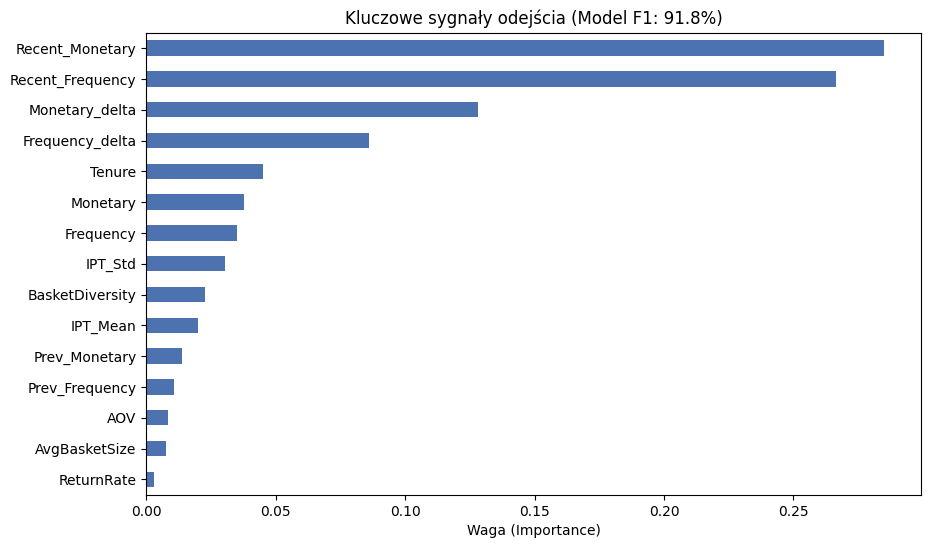


--- PODZIAŁ PORTFELA KLIENTÓW ---
Risk_Segment
🔴 Critical (Stracony)     484
🟢 Safe (Bezpieczny)       468
🟡 Watchlist (Obserwuj)    177
🟠 At Risk (Ratuj!)         42
Name: count, dtype: int64


In [119]:
import joblib

# --- KROK 1: CO JEST WAŻNE DLA "MISTRZA"? ---
# Sprawdźmy, czy po strojeniu zmieniły się priorytety modelu
importances = rf_model.feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh', color='#4c72b0')
plt.title(f'Kluczowe sygnały odejścia (Model F1: {rf_grid.best_score_:.1%})')
plt.xlabel('Waga (Importance)')
plt.show()


# --- KROK 2: SEGMENTACJA I LISTA KASOWA ---
# Generujemy prognozy dla zbioru testowego używając najlepszego modelu
churn_probs = rf_model.predict_proba(X_test)[:, 1] # Prawdopodobieństwo klasy 1

# Tworzymy tabelę wyników
final_results = pd.DataFrame({
    'Actual_Status': y_test,
    'Churn_Probability': churn_probs
}, index=X_test.index)

# Definiujemy segmenty (możesz dostosować progi biznesowo)
def get_segment(prob):
    if prob >= 0.80: return '🔴 Critical (Stracony)'
    if prob >= 0.50: return '🟠 At Risk (Ratuj!)'
    if prob >= 0.20: return '🟡 Watchlist (Obserwuj)'
    return '🟢 Safe (Bezpieczny)'

final_results['Risk_Segment'] = final_results['Churn_Probability'].apply(get_segment)

# Statystyki
print("\n--- PODZIAŁ PORTFELA KLIENTÓW ---")
print(final_results['Risk_Segment'].value_counts())